# Test PPO vs CACLA+VAR sur LunarLanderContinuous

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Normal
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple
from collections import deque
import copy

In [2]:
env = gym.make("LunarLanderContinuous-v2")

In [3]:
print(env.observation_space)
print(env.action_space)

Box(-inf, inf, (8,), float32)
Box(-1.0, 1.0, (2,), float32)


In [8]:
nb_episode = 1000
action_space = 2
observation_space = 8
gamma = 0.9

## PPO

In [20]:
action_space = 2
observation_space = 8
gamma = 0.9


TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'a_log_p', 'r', 's_'])

class ActorNet(nn.Module):

    def __init__(self):
        super(ActorNet, self).__init__()
        self.fc = nn.Linear(observation_space, 100)
        self.mu_head = nn.Linear(100, action_space)
        self.sigma_head = nn.Linear(100, action_space)

    def forward(self, x):
        x = F.relu(self.fc(x))
        mu = 2.0 * F.tanh(self.mu_head(x))
        sigma = F.softplus(self.sigma_head(x))
        return (mu, sigma)


class CriticNet(nn.Module):

    def __init__(self):
        super(CriticNet, self).__init__()
        self.fc = nn.Linear(observation_space, 100)
        self.v_head = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.fc(x))
        state_value = self.v_head(x)
        return state_value


class Agent():

    clip_param = 0.2
    max_grad_norm = 0.5
    ppo_epoch = 10
    buffer_capacity, batch_size = 1000, 32

    def __init__(self):
        self.training_step = 0
        self.anet = ActorNet().float()
        self.cnet = CriticNet().float()
        self.buffer = []
        self.counter = 0

        self.optimizer_a = optim.Adam(self.anet.parameters(), lr=1e-4)
        self.optimizer_c = optim.Adam(self.cnet.parameters(), lr=3e-4)

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            (mu, sigma) = self.anet(state)
        dist = Normal(mu, sigma)
        action = dist.sample()
        action_log_prob = dist.log_prob(action)
        action = action.clamp(-1.0, 1.0)
        return action.detach().numpy(), action_log_prob.detach().numpy()

    def get_value(self, state):

        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            state_value = self.cnet(state)
        return state_value.item()

    def save_param(self):
        torch.save(self.anet.state_dict(), 'param/ppo_anet_params.pkl')
        torch.save(self.cnet.state_dict(), 'param/ppo_cnet_params.pkl')

    def store(self, transition):
        self.buffer.append(transition)
        self.counter += 1
        return self.counter % self.buffer_capacity == 0

    def update(self):
        td_error_list = list()
        
        self.training_step += 1

        s = torch.tensor([t.s for t in self.buffer], dtype=torch.float)
        a = torch.tensor([t.a for t in self.buffer], dtype=torch.float).view(-1, 1)
        r = torch.tensor([t.r for t in self.buffer], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in self.buffer], dtype=torch.float)

        old_action_log_probs = torch.tensor(
            [t.a_log_p for t in self.buffer], dtype=torch.float).view(-1, 1)

        r = (r - r.mean()) / (r.std() + 1e-5)
        with torch.no_grad():
            target_v = r + gamma * self.cnet(s_)

        adv = (target_v - self.cnet(s)).detach()

        for _ in range(self.ppo_epoch):
            for index in BatchSampler(
                    SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, False):

                (mu, sigma) = self.anet(s[index])
                dist = Normal(mu, sigma)
                action_log_probs = dist.log_prob(a[index])
                ratio = torch.exp(action_log_probs - old_action_log_probs[index])
                
                td_error = adv[index]
                td_error_list.append(td_error.sum())
                mask = (td_error > 0).squeeze()
                
                
                # update critic
                value_loss = F.smooth_l1_loss(self.cnet(s[index]), target_v[index])
                self.optimizer_c.zero_grad()
                value_loss.backward()
                nn.utils.clip_grad_norm_(self.cnet.parameters(), self.max_grad_norm)
                self.optimizer_c.step()
                
                # update actor
                surr1 = (ratio * adv[index])
                surr2 = (torch.clamp(ratio, 1.0 - self.clip_param,
                                    1.0 + self.clip_param) * adv[index])
                action_loss = -torch.min(surr1, surr2).mean()
                self.optimizer_a.zero_grad()
                action_loss.backward()
                nn.utils.clip_grad_norm_(self.anet.parameters(), self.max_grad_norm)
                self.optimizer_a.step()

        del self.buffer[:]
        return td_error_list

In [22]:
env = gym.make('LunarLanderContinuous-v2')
print("import reussi")
env.seed(1)
agent = Agent()
training_records = []
state = env.reset()
list_rewards = list()
td_error_list = list()

for i_ep in range(nb_episode):
    score = 0
    state = env.reset()
    done = False
    while not done :
        action, action_log_prob = agent.select_action(state)            
        state_, reward, done,_ = env.step(action[0])
        if agent.store(Transition(state, action, action_log_prob, (reward), state_)):
            res_td_error = agent.update()
            td_error_list.append( sum(res_td_error)/len(res_td_error) )
        score += reward
        state = state_


    list_rewards.append(score)
    training_records.append(TrainingRecord(i_ep, score))
    if i_ep % 5 == 0 :

        print(f"Episode {i_ep} - score : {score} ")

last_rewards = np.array(list_rewards)
td_error_list = np.array(td_error_list)

import reussi
Episode 0 - score : -610.1513857610062 
Episode 5 - score : -687.6476772010028 
Episode 10 - score : -462.5658043737883 
Episode 15 - score : -688.2084295676586 
Episode 20 - score : -462.13202557268573 
Episode 25 - score : -538.1381383430304 
Episode 30 - score : -268.76313708896043 
Episode 35 - score : -590.7143508748838 
Episode 40 - score : -652.7730951508596 
Episode 45 - score : -843.1476615072104 
Episode 50 - score : -549.847543159949 
Episode 55 - score : -658.5587745118048 
Episode 60 - score : -273.499497285312 
Episode 65 - score : -744.5318835372103 
Episode 70 - score : -699.1465988695788 
Episode 75 - score : -733.5632604152032 
Episode 80 - score : -544.4676235918915 
Episode 85 - score : -519.4880257481052 
Episode 90 - score : -584.2085002891934 
Episode 95 - score : -328.3475733648702 
Episode 100 - score : -386.31976362153034 
Episode 105 - score : -677.4182832507047 
Episode 110 - score : -493.77556763502724 
Episode 115 - score : -452.1789646199179

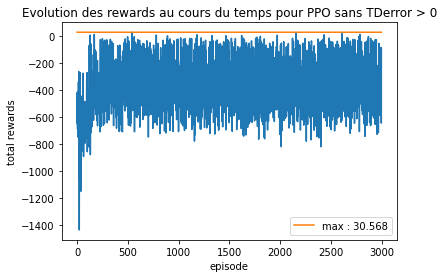

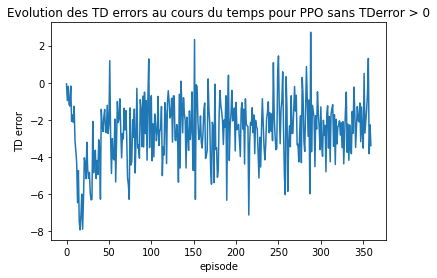

In [26]:
plt.figure()
plt.plot(last_rewards)
plt.plot([max(last_rewards) for _ in range(len(last_rewards))], label = f"max : {round(max(last_rewards),3)}")
plt.xlabel("episode")
plt.ylabel("total rewards")
plt.legend()
plt.title("Evolution des rewards au cours du temps pour PPO sur LunarLanderContinuous")
plt.show()


plt.figure()
plt.plot(td_error_list)
plt.xlabel("episode")
plt.ylabel("TD error")
plt.title("Evolution des TD errors au cours du temps pour PPO sur LunarLanderContinuous")
plt.show()

In [9]:
class ActorNetwork(nn.Module) :
    
    def __init__(
        self
    ) :
        
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(observation_space, 100),
            nn.ReLU(),
            nn.Linear(100, action_space)
        )
        
    def forward(self,x) :
        return self.net(x)
    
    
class CriticNetwork(nn.Module) :
    
    def __init__(
        self
    ) :
        
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(observation_space, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
        
    def forward(self,x) :
        return self.net(x)

class CACLAVAR() :
    
    def __init__(
        self,
        learning_rate_critic : float,
        learning_rate_actor : float,
        discount_factor : float,
        epsilon : float,
        epsilon_min : float,
        epsilon_decay : float,
        sigma : float,
        nb_episode : int,
        nb_tests : int,
        test_frequency : int,
        env,
        actor_network,
        critic_network,
        exploration_strategy : str = "gaussian",
        verbose_mode : bool = True
    ) :
        
        self.learning_rate_critic = learning_rate_critic
        self.learning_rate_actor = learning_rate_actor
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.sigma = np.zeros(2) + sigma
        self.nb_episode = nb_episode
        self.nb_tests = nb_tests
        self.test_frequency = test_frequency
        self.env = env
        self.actor_network = actor_network
        self.critic_network = critic_network
        self.exploration_strategy = exploration_strategy
        self.verbose_mode = verbose_mode
        
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        
        self.optimizer_actor= torch.optim.Adam(self.actor_network.parameters(),lr=self.learning_rate_actor)
        self.optimizer_critic = torch.optim.Adam(self.critic_network.parameters(),lr=self.learning_rate_critic)
        
        self.best_model = copy.deepcopy(self.actor_network)
        self.best_value = -1e10
        self.var = 1.0
        self.beta = 0.001
        self.iteration = 0
        
    def learning(self) : 
        
        self.list_rewards_mean = list()
        self.list_rewards_std = list()
        self.list_iteration = list()
        
        for episode in range(self.nb_episode) :
        
            state = self.env.reset()

            done = False

            while not done :
                
                self.iteration += 1
            
                state_t = torch.as_tensor(state , dtype=torch.float32)
                
                action = self.get_action(state_t)
                
                new_state, reward, done,_ = self.env.step(action)
                
                new_state_t = torch.as_tensor(new_state , dtype=torch.float32)
        
                reward_t = torch.as_tensor(reward , dtype=torch.float32)
            
                with torch.no_grad():
                    td_error = (reward_t + 
                                (self.discount_factor * 
                                           (1 - done) * 
                                           self.critic_network(new_state_t)
                                ) 
                                - self.critic_network(state_t))
                    
                # update var
                self.var = (1-self.beta) * self.var + (self.beta*td_error.item()**2)
                
                # learning critic
                loss_critic = - td_error.detach() * self.critic_network(state_t)

                self.optimizer_critic.zero_grad()
                loss_critic.backward()
                self.optimizer_critic.step()
                
                if td_error > 0 :
                    
                    nb_update = int(np.ceil(td_error.item() / np.sqrt(self.var)))
                    
                    for _ in range(nb_update) : 
                    
                        action_t = torch.as_tensor(action , dtype=torch.float32)

                        # learning actor
                        loss_actor = - ( (action_t - self.actor_network(state_t).detach()) * self.actor_network(state_t) ).mean()

                        self.optimizer_actor.zero_grad()
                        loss_actor.backward()
                        self.optimizer_actor.step()
                
                state = new_state
            
            # testing
            
            if episode % self.test_frequency == 0 :
                rewards_tests = list()
                for t in range(self.nb_tests) :
                    rewards_tests.append(self.test())
                rewards_tests = np.array(rewards_tests)
                    
                self.list_rewards_mean.append(rewards_tests.mean())
                self.list_rewards_std.append(rewards_tests.std())
                self.list_iteration.append(self.iteration)
                
                if self.verbose_mode :
                    print(f"{episode}/{self.nb_episode} - iteration : {self.iteration} - rewards value test : {rewards_tests.mean()} - best value : {self.best_value}")
                
                if self.best_value < rewards_tests.mean() :
                    self.best_model.load_state_dict(self.actor_network.state_dict())
                    self.best_value = rewards_tests.mean()
                    
                
    def get_action(self,state_t) :
        if self.exploration_strategy == "gaussian" :
            return torch.as_tensor(
                        np.array(
                            np.random.normal(loc=self.actor_network(state_t).detach().numpy(),
                            scale=self.sigma,size=(1,action_space))
                        ),
                        dtype=torch.float32
                )[0].detach().numpy()
        elif self.exploration_strategy == "egreedy" :
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            if np.random.rand() > self.epsilon :
                return self.actor_network(state_t).detach().numpy()
            else :
                
                return torch.as_tensor(
                        np.array(
                            np.random.normal(loc=self.actor_network(state_t).detach().numpy(),
                            scale=self.sigma,size=(1,action_space))
                        ),
                        dtype=torch.float32
                )[0].detach().numpy()
        else :
            raise Exception("The exploration strategy must be gaussian or egreedy")    
        
        
    def test(self) :  
        
        list_rewards = list()
        state = self.env.reset()
        done = False
        while not done :
            state_t = torch.as_tensor(state , dtype=torch.float32)
            action =  self.actor_network(state_t).detach().numpy()
            new_state, reward, done,_ = self.env.step(action)
            list_rewards.append(reward)
            state = new_state
        return sum(list_rewards)

In [26]:
anet = ActorNetwork()
cnet = CriticNetwork()
caclavar = CACLAVAR(
        learning_rate_critic = 3e-4,
        learning_rate_actor = 1e-4,
        discount_factor = 0.90,
        epsilon = 1.0,
        epsilon_min = 0.01,
        epsilon_decay = 0.01,
        sigma = 0.3,
        nb_episode = nb_episode,
        nb_tests = 3,
        test_frequency = 10,
        env = env,
        actor_network = anet,
        critic_network = cnet,
        exploration_strategy = "gaussian",
        verbose_mode = True
    )

In [27]:
caclavar.learning()

0/1000 - iteration : 108 - rewards value test : -308.57548685260895 - best value : -10000000000.0
10/1000 - iteration : 1346 - rewards value test : -303.7377311067164 - best value : -308.57548685260895
20/1000 - iteration : 2575 - rewards value test : -418.71426916187335 - best value : -303.7377311067164
30/1000 - iteration : 3558 - rewards value test : -339.85126404179255 - best value : -303.7377311067164
40/1000 - iteration : 4474 - rewards value test : -129.41952761562854 - best value : -303.7377311067164
50/1000 - iteration : 5365 - rewards value test : -231.9884321331643 - best value : -129.41952761562854
60/1000 - iteration : 6303 - rewards value test : -91.35995468963294 - best value : -129.41952761562854
70/1000 - iteration : 7239 - rewards value test : -142.1163747802635 - best value : -91.35995468963294
80/1000 - iteration : 8290 - rewards value test : -333.7314252283202 - best value : -91.35995468963294
90/1000 - iteration : 9684 - rewards value test : -427.19547079927605 - 

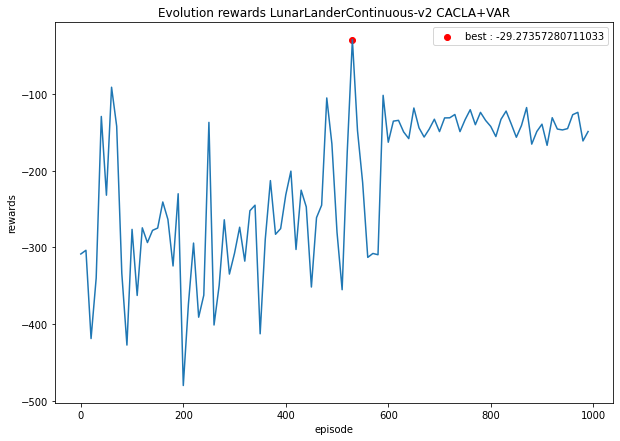

In [28]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(0,caclavar.nb_episode,caclavar.test_frequency) , caclavar.list_rewards_mean)
plt.scatter(caclavar.list_rewards_mean.index(max(caclavar.list_rewards_mean))*caclavar.test_frequency,max(caclavar.list_rewards_mean),c='r',label=f"best : {max(caclavar.list_rewards_mean)}")
plt.title("Evolution rewards LunarLanderContinuous-v2 CACLA+VAR")
plt.xlabel("episode")
plt.ylabel("rewards")
plt.legend()
plt.show()

In [29]:
from tqdm import tqdm

In [30]:
nb_tests = 100
list_result = list()
for t in tqdm(range(nb_tests)) :
    cum_sum = 0.0
    state = env.reset()
    done = False
    while not done :
        state_t = torch.as_tensor(state , dtype=torch.float32)
        action =  caclavar.best_model(state_t).detach().numpy()
        new_state, reward, done,_ = env.step(action)
        cum_sum += reward
        state = new_state
    list_result.append(cum_sum)

100%|█████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


In [31]:
list_result = np.array(list_result)
print(f"Rewards : {list_result.mean()} +/- {list_result.std()}")

Rewards : -124.28589348313278 +/- 121.35530383659301
